### Kaggle - Web Traffic Time Series Forecasting

## Model 06 - Convolutional Neural Network

### v3 scale group

by Louis Yang

Split into groups based on the scale of visit number and train individual model in each group

Original model "model_06_CNN_2_validation"

In [267]:
model_name = 'model_06_CNN_3_scale_group_4_long_filter_3'

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import gc  # Python garbage collect

## Input

In [3]:
print('%%% Reading data train_1.csv ... ', end = '', flush = True)
input_df = pd.read_csv("../data/train_1.csv")
print('done!')

%%% Reading data train_1.csv ... done!


In [4]:
input_df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [5]:
input_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 609.8+ MB


## Processing Data
Generate training set and test (predict) set

### Day of week alignment

In [6]:
from datetime import datetime
def weekday(datestr):
    return datetime.strptime(datestr,'%Y-%m-%d').weekday()
def daydiff(dstr1,dstr2):
    return datetime.strptime(dstr1,'%Y-%m-%d') - datetime.strptime(dstr2,'%Y-%m-%d') 

We need to predict output (Y_output_pred) start from Sunday (6) for data set 1. (0: Monday, 6: Sunday)

In [7]:
# We take the x_length + y_length days of data only
# This part then split into x_length as input X and y_length as output Y
x_length = 63  # input period
y_length = 63  # predict period

Shift everything forward by y_length = 63 days to allows self testing without Kaggle

In [8]:
X_input_first_day = input_df.columns[-x_length-y_length-364]
X_input_final_day = input_df.columns[-1-y_length-364]
X_input_first_day, X_input_final_day

('2015-08-30', '2015-10-31')

In [9]:
daydiff(X_input_first_day, X_input_final_day)

datetime.timedelta(-62)

In [10]:
X_output_first_day = input_df.columns[-x_length-y_length]
X_output_final_day = input_df.columns[-1-y_length]
X_output_first_day, X_output_final_day

('2016-08-28', '2016-10-29')

In [11]:
daydiff(X_output_first_day, X_output_final_day)

datetime.timedelta(-62)

In [12]:
weekday(X_input_first_day), weekday(X_output_first_day)

(6, 6)

Both are Wednesday (2).

Y_output_first_day = '2017-01-01'; Y_output_final_day = '2017-03-01'
daydiff(Y_output_first_day,Y_output_final_day)

In [13]:
Y_input_first_day = input_df.columns[-364-y_length]
Y_input_final_day = input_df.columns[-1-364]
Y_input_first_day, Y_input_final_day

('2015-11-01', '2016-01-02')

In [14]:
daydiff(Y_input_first_day, Y_input_final_day)

datetime.timedelta(-62)

In [15]:
Y_output_first_day = input_df.columns[-y_length]
Y_output_final_day = input_df.columns[-1]
Y_output_first_day, Y_output_final_day

('2016-10-30', '2016-12-31')

In [16]:
daydiff(Y_output_first_day, Y_output_final_day)

datetime.timedelta(-62)

In [17]:
weekday(Y_input_first_day), weekday(Y_output_first_day)

(6, 6)

Both are Sunday (6).

### Data range reduce
Select x_length + y_length days of data as training set

where x_length = 60, y_length = 60 by default for training set 1.

In [18]:
X_input_first_day, Y_input_final_day

('2015-08-30', '2016-01-02')

input_data contains X_input and Y_input array

In [19]:
input_date_range = input_df.columns[-x_length-y_length-364:-364]; input_date_range

Index(['2015-08-30', '2015-08-31', '2015-09-01', '2015-09-02', '2015-09-03',
       '2015-09-04', '2015-09-05', '2015-09-06', '2015-09-07', '2015-09-08',
       ...
       '2015-12-24', '2015-12-25', '2015-12-26', '2015-12-27', '2015-12-28',
       '2015-12-29', '2015-12-30', '2015-12-31', '2016-01-01', '2016-01-02'],
      dtype='object', length=126)

In [20]:
input_data = input_df[input_date_range].values; #input_data

In [21]:
input_data_num = np.nan_to_num(input_data); input_data_num

array([[  9.,  10.,   9., ...,  18.,   9.,  16.],
       [ 22.,  11.,  81., ...,   9.,   7.,  15.],
       [  1.,   3.,   4., ...,   2.,   2.,   0.],
       ..., 
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

In [22]:
input_data_num.shape

(145063, 126)

In [23]:
X_output_first_day, Y_output_final_day

('2016-08-28', '2016-12-31')

output_data for this self-testing script contains both X_output and Y_output

In [24]:
output_date_range = input_df.columns[-x_length-y_length:]; output_date_range

Index(['2016-08-28', '2016-08-29', '2016-08-30', '2016-08-31', '2016-09-01',
       '2016-09-02', '2016-09-03', '2016-09-04', '2016-09-05', '2016-09-06',
       ...
       '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-25', '2016-12-26',
       '2016-12-27', '2016-12-28', '2016-12-29', '2016-12-30', '2016-12-31'],
      dtype='object', length=126)

In [25]:
output_data = input_df[output_date_range].values; #output_data

In [26]:
output_data_num = np.nan_to_num(output_data); output_data_num

array([[  18.,   26.,    8., ...,   19.,   18.,   20.],
       [  25.,   22.,  144., ...,   45.,   26.,   20.],
       [   3.,    5.,    4., ...,    3.,    4.,   17.],
       ..., 
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.]])

In [27]:
output_data_num.shape

(145063, 126)

### View

In [28]:
def arr_info(arr_list):
    for arr in arr_list:
        print(arr.shape, arr.min(), arr.max(), np.median(arr), arr.std())

In [29]:
def view(x, xlim=None, ylim=None, yscale='linear', title=None, show=True):
    plt.yscale(yscale)
    plt.plot(x)
    if ylim: plt.ylim(ylim)
    if xlim: plt.xlim(xlim)
    if title: plt.title(title)
    if show: plt.show()
def viewi(X, i, xlim=None, ylim=None, yscale='linear', show=True):
    view(X[i], xlim=xlim, ylim=ylim, yscale=yscale, title='i = ' + str(i), show=show)
def examine(X, n=5, xlim=None, ylim=None):
    '''randomly show some example in feature and label'''
    n_X = len(X)
    view_list = np.random.choice(n_X, min(n, n_X), replace=False)
    for i in view_list:
        viewi(X, i, xlim=xlim, ylim=ylim)
    return view_list

examine(input_data)

## Transform Data

### Log

In [30]:
def log(X):
    return np.log10(X + 1.0)
def unlog(X):
    return np.clip(np.power(10., X) - 1.0, 0.0, None)

In [31]:
input_data_log = log(input_data_num)
output_data_log = log(output_data_num)

##### Check Log transformation

In [32]:
output_data_log.shape, output_data.shape

((145063, 126), (145063, 126))

In [33]:
input_data_log.shape, input_data.shape

((145063, 126), (145063, 126))

In [34]:
input_data_log

array([[ 1.        ,  1.04139269,  1.        , ...,  1.2787536 ,
         1.        ,  1.23044892],
       [ 1.36172784,  1.07918125,  1.91381385, ...,  1.        ,
         0.90308999,  1.20411998],
       [ 0.30103   ,  0.60205999,  0.69897   , ...,  0.47712125,
         0.47712125,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [35]:
output_data_log

array([[ 1.2787536 ,  1.43136376,  0.95424251, ...,  1.30103   ,
         1.2787536 ,  1.32221929],
       [ 1.41497335,  1.36172784,  2.161368  , ...,  1.66275783,
         1.43136376,  1.32221929],
       [ 0.60205999,  0.77815125,  0.69897   , ...,  0.60205999,
         0.69897   ,  1.25527251],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [36]:
# Check inverse log transformation
input_data_log_tt = unlog(input_data_log)
input_data_log_tt_dif = input_data_log_tt - input_data_num
input_data_log_tt_dif.min(), input_data_log_tt_dif.max()

(-1.862645149230957e-08, 1.862645149230957e-08)

In [37]:
# Check inverse log transformation
output_data_log_tt = unlog(output_data_log)
output_data_log_tt_dif = output_data_log_tt - output_data_num
output_data_log_tt_dif.min(), output_data_log_tt_dif.max()

(-2.9802322387695313e-08, 2.6077032089233398e-08)

### Normalization (Shift and Scale)

#### Compute Median and Stdev

In [38]:
input_center = np.nanmedian(input_data_log[:,:x_length], axis=-1).reshape(-1,1)
input_center  # remember sample-wised center

array([[ 1.04139269],
       [ 1.23044892],
       [ 0.60205999],
       ..., 
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]])

In [39]:
input_scale = np.nanstd(input_data_log[:,:x_length], axis=-1).reshape(-1,1)
input_scale[input_scale == 0.0] = 1.0  # Prevent divid by zero
input_scale  # remember sample-wised scale

array([[ 0.22974401],
       [ 0.23685744],
       [ 0.27363311],
       ..., 
       [ 1.        ],
       [ 1.        ],
       [ 1.        ]])

In [40]:
output_center = np.nanmedian(output_data_log[:,:x_length], axis=-1).reshape(-1,1)
output_center  # remember sample-wised center

array([[ 1.2787536 ],
       [ 1.44715803],
       [ 0.69897   ],
       ..., 
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]])

In [41]:
output_scale = np.nanstd(output_data_log[:,:x_length], axis=-1).reshape(-1,1)
output_scale[output_scale == 0.0] = 1.0  # Prevent divid by zero
output_scale  # remember sample-wised scale

array([[ 0.19725496],
       [ 0.25052371],
       [ 0.21878369],
       ..., 
       [ 1.        ],
       [ 1.        ],
       [ 1.        ]])

##### Check zero in scale

In [42]:
# Check if there is any 0. in input_scale
input_scale[input_scale == 0.]

array([], dtype=float64)

In [43]:
# Check if there is any 0. in output_scale
output_scale[output_scale == 0.]

array([], dtype=float64)

#### Transform by Median and Stdev

In [44]:
def transform(data_ori, center, scale):
    return (data_ori - center) / scale
def untransform(data, center, scale):
    return data * scale + center

In [45]:
# Normalize the input_data and output_data
input_data_norm = transform(input_data_log, input_center, input_scale)
output_data_norm = transform(output_data_log, output_center, output_scale)

##### Check median and stdev transformations

In [46]:
def check_nan(X):
    return [x for x in X if np.isnan(x).any()]

In [47]:
check_nan(input_data_norm), check_nan(output_data_norm)  # Check if there is any nan in the input_data

([], [])

In [48]:
# Check inverse scale transformation
input_data_norm_it = untransform(input_data_norm, input_center, input_scale)
input_data_norm_it_dif = input_data_norm_it - input_data_log
input_data_norm_it_dif.min(), input_data_norm_it_dif.max()

(-8.8817841970012523e-16, 8.8817841970012523e-16)

In [49]:
# Check inverse scale transformation
output_data_norm_it = untransform(output_data_norm, output_center, output_scale)
output_data_norm_it_dif = output_data_norm_it - output_data_log
output_data_norm_it_dif.min(), output_data_norm_it_dif.max()

(-8.8817841970012523e-16, 8.8817841970012523e-16)

## Scale Investigation

#### Input median

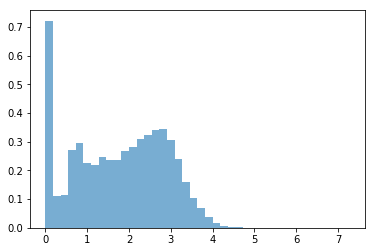

In [50]:
plt.hist(input_center, bins=40, normed=True, alpha=0.6)
plt.show()

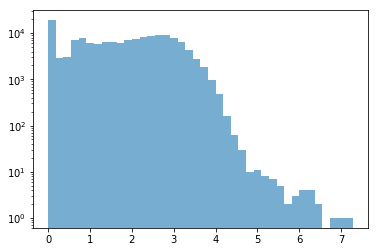

In [51]:
plt.hist(input_center, bins=40, alpha=0.6)
plt.yscale('log')
plt.show()

#### Output median

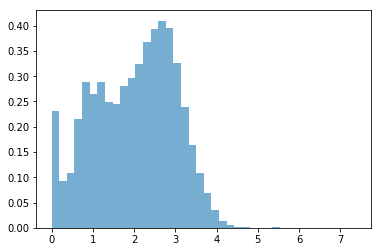

In [52]:
plt.hist(output_center, bins=40, normed=True, alpha=0.6)
plt.show()

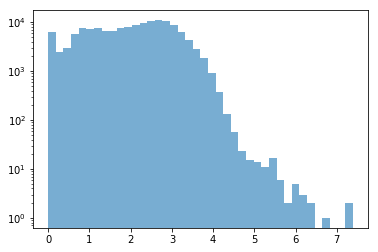

In [53]:
plt.hist(output_center, bins=40, alpha=0.6)
plt.yscale('log')
plt.show()

#### Input std

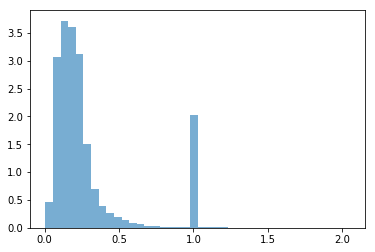

In [54]:
plt.hist(input_scale, bins=40, normed=True, alpha=0.6)
plt.show()

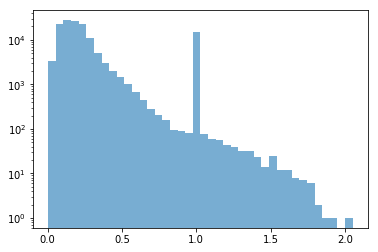

In [55]:
plt.hist(input_scale, bins=40, alpha=0.6)
plt.yscale('log')
plt.show()

#### Output std

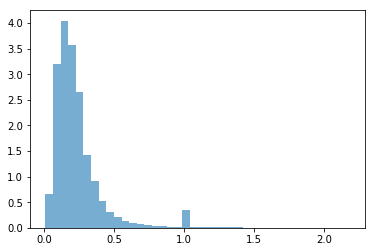

In [56]:
plt.hist(output_scale, bins=40, normed=True, alpha=0.6)
plt.show()

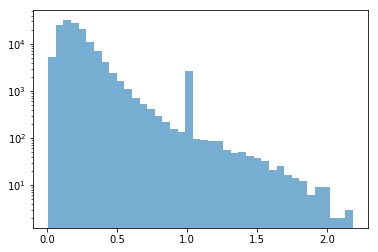

In [57]:
plt.hist(output_scale, bins=40, alpha=0.6)
plt.yscale('log')
plt.show()

### Group index based on scale of median (center)

In [208]:
def group_index(logx):
    if logx == 0.: return 0
    elif logx < 2.0: return 1
    elif logx < 4.0: return 2
    elif logx < 5.0: return 3
    else: return 4
group_index_v = np.vectorize(group_index)
gp_list = list(range(5)); gp_list

[0, 1, 2, 3, 4]

In [209]:
input_gp = group_index_v(input_center).reshape(-1)
output_gp = group_index_v(output_center).reshape(-1)
input_gp, output_gp

(array([1, 1, 1, ..., 0, 0, 0]), array([1, 1, 1, ..., 0, 0, 0]))

In [210]:
# list for original index
gp_input_counts = [0] * len(gp_list)
for x in input_gp: gp_input_counts[x] += 1
gp_input_counts

[19038, 58665, 66572, 746, 42]

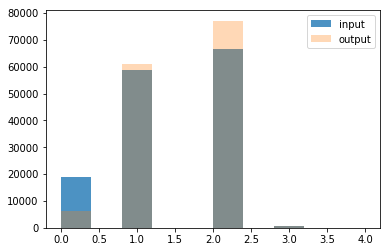

In [211]:
plt.hist(input_gp, alpha=0.8, label='input')
plt.hist(output_gp, alpha=0.3, label='output')
plt.yscale('linear')
plt.legend()
plt.show()

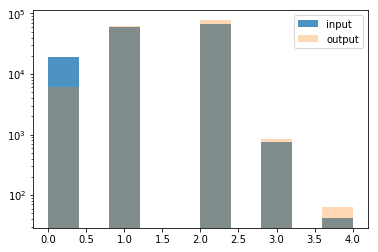

In [212]:
plt.hist(input_gp, alpha=0.8, label='input')
plt.hist(output_gp, alpha=0.3, label='output')
plt.yscale('log')
plt.legend()
plt.show()

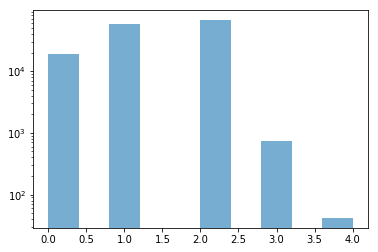

In [213]:
plt.hist(input_gp, alpha=0.6)
plt.yscale('log')
plt.show()

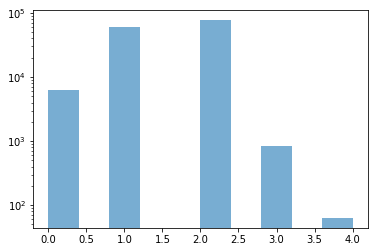

In [214]:
plt.hist(output_gp, alpha=0.6)
plt.yscale('log')
plt.show()

In [215]:
# list for original index
gp_output_counts = [0] * len(gp_list)
for x in output_gp: gp_output_counts[x] += 1
gp_output_counts

[6191, 60859, 77113, 837, 63]

## Make (X,Y) pairs data from data set

day_shift = 0

def make_XY(data, x_length=x_length, y_length=y_length, shift=day_shift):
    if shift == 0:
        return data[:, -x_length-y_length:-y_length], data[:, -y_length:]
    else:
        return data[:, -x_length-y_length-shift:-y_length-shift], data[:, -y_length-shift:-shift]

In [216]:
X_input = input_data_norm[:, :x_length]
Y_input = input_data_norm[:, -y_length:]
X_input.shape, Y_input.shape

((145063, 63), (145063, 63))

In [217]:
X_output = output_data_norm[:, :x_length]
Y_output = output_data_norm[:, -y_length:]
X_output.shape, Y_output.shape

((145063, 63), (145063, 63))

#### Original data

In [218]:
X_input_ori = input_data_num[:, :x_length]
Y_input_ori = input_data_num[:, -y_length:]
X_output_ori = output_data_num[:, :x_length]
Y_output_ori = output_data_num[:, -y_length:]

#### Backward compatible

In [219]:
X_train = X_input
Y_train = Y_input

In [220]:
X_val = X_output
Y_val = Y_output

In [221]:
X_train_ori = X_input_ori
Y_train_ori = Y_input_ori
X_val_ori = X_output_ori
Y_val_ori = Y_output_ori

In [222]:
train_scale = input_scale
train_center = input_center
val_scale = output_scale
val_center = output_scale

#### Check

X_input, input_data_norm[:,:x_length]

Y_input, input_data_norm[:,-y_length:]

X_output, output_data_norm[:,:x_length]

Y_output, output_data_norm[:,-y_length:]

X_input_ori, input_data_num

Y_input_ori, input_data_num

X_output_ori, output_data_num

Y_output_ori, output_data_num

In [223]:
arr_info((X_input, Y_input, X_output, Y_output, 
          X_input_ori, Y_input_ori, X_output_ori, Y_output_ori))

(145063, 63) -7.56988545755 8.00100800101 0.0 0.968286226274
(145063, 63) -49.0306290766 105.67918878 0.0 1.8412771035
(145063, 63) -7.92981290925 8.00100800101 0.0 1.00961331391
(145063, 63) -57.6311852404 121.197360262 0.0 2.08074661026
(145063, 63) 0.0 21553554.0 75.0 64150.7195046
(145063, 63) 0.0 21366420.0 88.0 62373.0578871
(145063, 63) 0.0 33446984.0 139.0 87516.7023757
(145063, 63) 0.0 28342885.0 143.0 81329.6278471


### Split Data into Training and (Pseudo) Cross Validation Sets
Not using this. Use keras built-in feature for pseudo validation

def make_shuffle_index(n, seed=None):
    shuffle_index = np.array(list(range(n)))
    np.random.seed(seed)  # you can fix the initial seed for comparison purpose
    np.random.shuffle(shuffle_index)
    return shuffle_index

def using(array_ori, index_list):
    #return np.array([array_ori[i] for i in index_list])
    return np.take(array_ori, index_list, axis=0)

#Generate a shuffle list
shuffle_index = make_shuffle_index(len(X_input), seed=123)

Keep 10% of input data as validation set

#Split the index list into training and validation sets
n_val = int(len(X_input) * 0.1)
val_index = shuffle_index[:n_val]
train_index = shuffle_index[n_val:]

#Split the data sets according to the index list
X_train = using(X_input, train_index)
Y_train = using(Y_input, train_index)
X_val = using(X_input, val_index)
Y_val = using(Y_input, val_index)
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape

#### Split the untransformed data
Split the untransformed data in the same way for score estimation

train_data_num = using(input_data_num, train_index)
val_data_num = using(input_data_num, val_index)

X_train_ori, Y_train_ori = make_XY(train_data_num)
X_val_ori, Y_val_ori = make_XY(val_data_num)
X_train_ori.shape, Y_train_ori.shape, X_val_ori.shape, Y_val_ori.shape

train_center = using(input_center, train_index)
val_center = using(input_center, val_index)
train_scale = using(input_scale, train_index)
val_scale = using(input_scale, val_index)
train_center.shape, val_center.shape, train_scale.shape, val_scale.shape

#### Check if the inverse transformation is correct

#Undo transformation
X_train_tt = unlog(untransform(X_train, train_center, train_scale))

X_train_tt_diff = X_train_tt - X_train_ori
X_train_tt_diff.min(), X_train_tt_diff.max()

## Split X,Y data into groups

In [224]:
X_input[input_gp == 1].shape

(58665, 63)

In [225]:
X_input_list = [X_input[input_gp == gp] for gp in gp_list]
Y_input_list = [Y_input[input_gp == gp] for gp in gp_list]

In [226]:
X_output_list = [X_output[output_gp == gp] for gp in gp_list]
Y_output_list = [Y_output[output_gp == gp] for gp in gp_list]

## Neural Network?

In [165]:
from keras.models import Sequential
#from keras.layers import Conv1D
from keras.layers import Dense, Dropout, Flatten
from keras.losses import mean_squared_error
from keras.optimizers import Adam

Using TensorFlow backend.


### SMAPE
Symmetric mean absolute percentage error

https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error

In [166]:
import keras.backend as K

def k_smape(y_true, y_pred):
    '''Symmetric mean absolute percentage error for keras metric'''
    diff = K.abs((y_true - y_pred) / K.clip(K.abs(y_true) + K.abs(y_pred),
                                            K.epsilon(),
                                            None))
    return 200. * K.mean(diff, axis=-1)

In [167]:
def smape(y_true, y_pred, axis=None):
    '''Symmetric mean absolute percentage error'''
    diff = np.abs((y_true - y_pred) / 
                  np.clip(np.abs(y_true) + np.abs(y_pred), K.epsilon(),
                          None))
    return 200. * np.mean(diff, axis=axis)

In [227]:
# Benchmark SMAPE on the transformed data
smape(Y_train,X_train), smape(Y_val,X_val), smape(Y_train,Y_train)

(129.60436607794315, 141.08179051578969, 0.0)

In [228]:
# Benchmark SMAPE on the original data
smape(Y_train_ori,X_train_ori), smape(Y_val_ori,X_val_ori), \
smape(Y_train_ori,Y_train_ori)

(51.874930937113326, 57.677220315844565, 0.0)

Doing better than the first two scores are better than simply copy and past the previous result.

### Neural Network Model
With the flavor of convolutional neural network

In [170]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv1D
from keras.layers import Flatten
from keras.layers import Reshape

In [268]:
models = []
for gp in gp_list:
    print('Group:', gp)
    layer_0 = Input(shape=(x_length,))
    layer_t = Reshape((-1, 1))(layer_0)
    layer_t = Conv1D(60, kernel_size=3, activation='relu')(layer_t)
    layer_t = Flatten()(layer_t)
    layer_t = Dense(120, activation='relu')(layer_t)
    layer_t = Dropout(0.25)(layer_t)
    layer_t = Dense(120, activation='relu')(layer_t)
    layer_t = Dropout(0.5)(layer_t)
    layer_f = Dense(y_length)(layer_t)
    model = Model(inputs=layer_0, outputs=layer_f)
    model.compile(optimizer='adam',
                  loss='mean_squared_error', metrics=[k_smape])
    model.summary()
    models.append(model)

Group: 0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 63)                0         
_________________________________________________________________
reshape_11 (Reshape)         (None, 63, 1)             0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 61, 60)            240       
_________________________________________________________________
flatten_11 (Flatten)         (None, 3660)              0         
_________________________________________________________________
dense_31 (Dense)             (None, 120)               439320    
_________________________________________________________________
dropout_21 (Dropout)         (None, 120)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 120)               14520     
_

About 22s for 1 epoch on i5-750 CPU

In [269]:
epochs_list = [40,40,40,60,60]

In [270]:
hists = []
for (gp, model, X_in, Y_in, epochs) in zip(gp_list, models,
                                   X_input_list, Y_input_list, 
                                   epochs_list):
    print('Group:',gp)
    hist = model.fit(X_in, Y_in, batch_size=128, 
                     epochs=epochs, 
                     validation_split=0.05, verbose=2)
    #validation_data=(X_val, Y_val))
    hists.append(hist)

Group: 0
Train on 18086 samples, validate on 952 samples
Epoch 1/40
3s - loss: 4.3977 - k_smape: 183.7770 - val_loss: 5.2783 - val_k_smape: 182.9342
Epoch 2/40
2s - loss: 4.0582 - k_smape: 182.7065 - val_loss: 5.4666 - val_k_smape: 183.7935
Epoch 3/40
2s - loss: 3.8410 - k_smape: 182.8590 - val_loss: 5.5799 - val_k_smape: 184.1017
Epoch 4/40
2s - loss: 3.6269 - k_smape: 182.6976 - val_loss: 6.0880 - val_k_smape: 184.8190
Epoch 5/40
2s - loss: 3.5577 - k_smape: 183.0031 - val_loss: 5.7281 - val_k_smape: 184.8052
Epoch 6/40
2s - loss: 3.6580 - k_smape: 182.6836 - val_loss: 5.4964 - val_k_smape: 184.7791
Epoch 7/40
2s - loss: 3.5306 - k_smape: 182.5159 - val_loss: 5.7620 - val_k_smape: 184.3565
Epoch 8/40
2s - loss: 3.3688 - k_smape: 182.8495 - val_loss: 5.6205 - val_k_smape: 184.6809
Epoch 9/40
2s - loss: 3.3793 - k_smape: 182.6476 - val_loss: 5.7087 - val_k_smape: 184.5071
Epoch 10/40
2s - loss: 3.4994 - k_smape: 182.4705 - val_loss: 5.4919 - val_k_smape: 184.6817
Epoch 11/40
2s - loss:

8s - loss: 2.6244 - k_smape: 121.3649 - val_loss: 3.0523 - val_k_smape: 121.3384
Epoch 9/40
8s - loss: 2.5849 - k_smape: 121.4314 - val_loss: 3.0310 - val_k_smape: 120.6143
Epoch 10/40
8s - loss: 2.5521 - k_smape: 121.0605 - val_loss: 3.0875 - val_k_smape: 121.5454
Epoch 11/40
8s - loss: 2.5190 - k_smape: 121.0174 - val_loss: 3.0166 - val_k_smape: 120.3197
Epoch 12/40
8s - loss: 2.4969 - k_smape: 120.7580 - val_loss: 3.0553 - val_k_smape: 121.5311
Epoch 13/40
8s - loss: 2.4697 - k_smape: 120.4626 - val_loss: 3.0519 - val_k_smape: 120.5129
Epoch 14/40
8s - loss: 2.4474 - k_smape: 120.4142 - val_loss: 3.0257 - val_k_smape: 120.7598
Epoch 15/40
8s - loss: 2.4156 - k_smape: 120.2697 - val_loss: 3.1042 - val_k_smape: 122.7839
Epoch 16/40
8s - loss: 2.4129 - k_smape: 120.1661 - val_loss: 3.0591 - val_k_smape: 121.9349
Epoch 17/40
8s - loss: 2.3802 - k_smape: 120.0105 - val_loss: 3.0362 - val_k_smape: 121.0395
Epoch 18/40
8s - loss: 2.3620 - k_smape: 119.9345 - val_loss: 3.0923 - val_k_smape:

0s - loss: 1.1282 - k_smape: 91.0040 - val_loss: 0.7819 - val_k_smape: 109.7261
Epoch 58/60
0s - loss: 1.1218 - k_smape: 92.0644 - val_loss: 0.8169 - val_k_smape: 109.8840
Epoch 59/60
0s - loss: 1.0950 - k_smape: 91.2856 - val_loss: 0.8194 - val_k_smape: 109.9502
Epoch 60/60
0s - loss: 1.1545 - k_smape: 91.4234 - val_loss: 0.8308 - val_k_smape: 110.5078
Group: 4
Train on 39 samples, validate on 3 samples
Epoch 1/60
0s - loss: 3.7218 - k_smape: 175.3649 - val_loss: 3.1501 - val_k_smape: 177.6065
Epoch 2/60
0s - loss: 3.6519 - k_smape: 169.6375 - val_loss: 3.0653 - val_k_smape: 166.2691
Epoch 3/60
0s - loss: 3.6037 - k_smape: 161.9763 - val_loss: 2.9920 - val_k_smape: 158.9737
Epoch 4/60
0s - loss: 3.5310 - k_smape: 157.3562 - val_loss: 2.9069 - val_k_smape: 152.1767
Epoch 5/60
0s - loss: 3.4826 - k_smape: 151.4028 - val_loss: 2.8281 - val_k_smape: 146.1448
Epoch 6/60
0s - loss: 3.4089 - k_smape: 146.5945 - val_loss: 2.7487 - val_k_smape: 141.0287
Epoch 7/60
0s - loss: 3.3771 - k_smape: 

### Training History

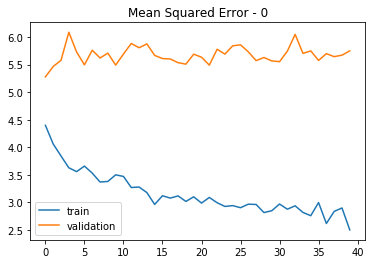

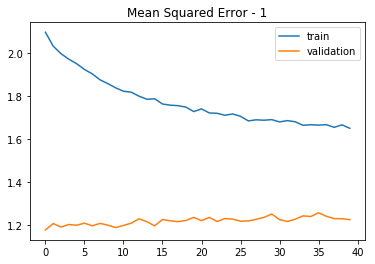

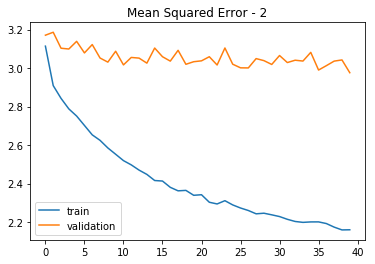

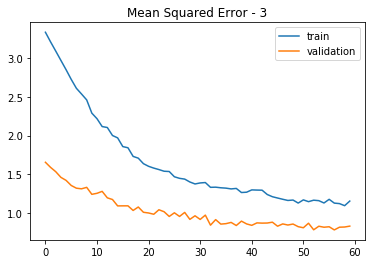

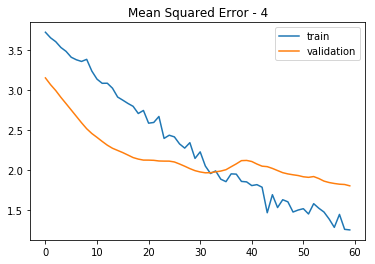

In [271]:
for (hist, gp) in zip(hists, gp_list):
    plt.plot(hist.history['loss'], label='train')
    plt.plot(hist.history['val_loss'], label='validation')
    plt.title('Mean Squared Error - ' + str(gp))
    plt.legend(); plt.show()

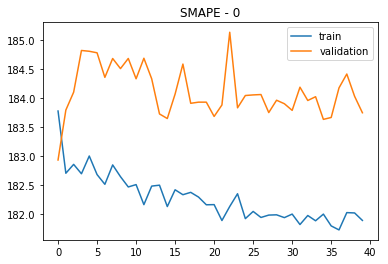

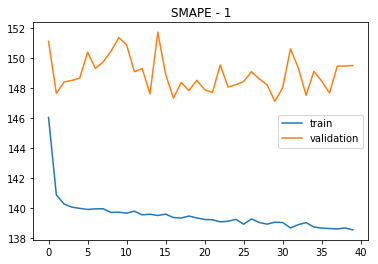

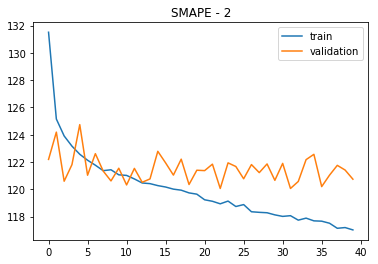

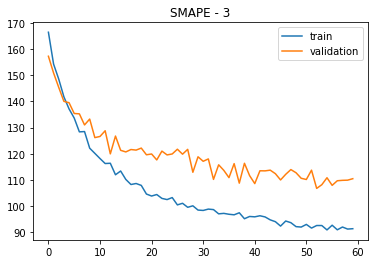

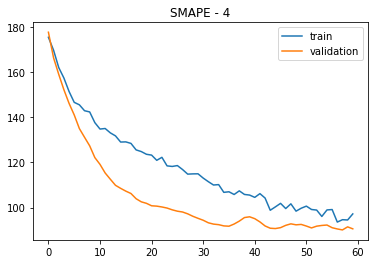

In [272]:
for (hist, gp) in zip(hists, gp_list):
    plt.plot(hist.history['k_smape'], label='train')
    plt.plot(hist.history['val_k_smape'], label='validation')
    plt.title('SMAPE - ' + str(gp))
    plt.legend(); plt.show()

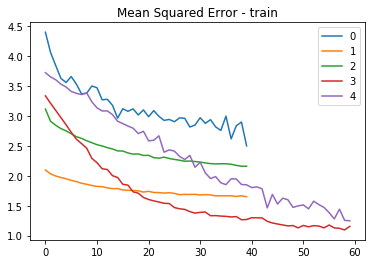

In [273]:
for (hist, gp) in zip(hists, gp_list):
    plt.plot(hist.history['loss'], label=gp)
plt.title('Mean Squared Error - train')
plt.legend(); plt.show()

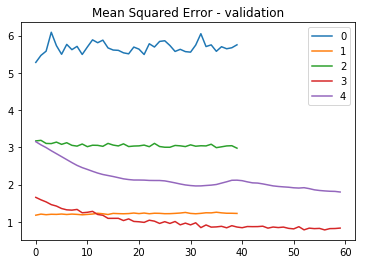

In [274]:
for (hist, gp) in zip(hists, gp_list):
    plt.plot(hist.history['val_loss'], label=gp)
plt.title('Mean Squared Error - validation')
plt.legend(); plt.show()

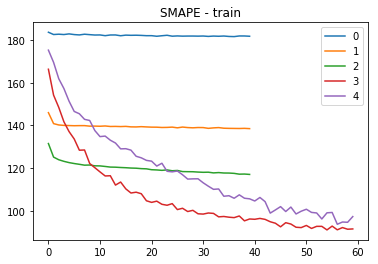

In [275]:
for (hist, gp) in zip(hists, gp_list):
    plt.plot(hist.history['k_smape'], label=gp)
plt.title('SMAPE - train')
plt.legend(); plt.show()

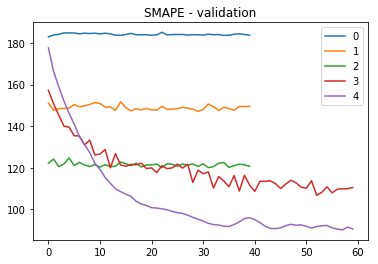

In [276]:
for (hist, gp) in zip(hists, gp_list):
    plt.plot(hist.history['val_k_smape'], label=gp)
plt.title('SMAPE - validation')
plt.legend(); plt.show()

### More Training

epochs_list2 = [0,10,0,0,10]

hists2 = []
for (gp, model, X_in, Y_in, epochs) in zip(gp_list, models,
                                   X_input_list, Y_input_list, 
                                   epochs_list2):
    hist = model.fit(X_in, Y_in, batch_size=128, 
                     epochs=epochs, 
                     validation_split=0.05)
    #validation_data=(X_val, Y_val))
    hists2.append(hist)

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs:
        plt.plot(hist.history['loss'], label='train')
        plt.plot(hist.history['val_loss'], label='validation')
        plt.title('Mean Squared Error - ' + str(gp))
        plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs:
        plt.plot(hist.history['k_smape'], label='train')
        plt.plot(hist.history['val_k_smape'], label='validation')
        plt.title('SMAPE - ' + str(gp))
        plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs:
        plt.plot(hist.history['loss'], label=gp)
plt.title('Mean Squared Error - train')
plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs: plt.plot(hist.history['val_loss'], label=gp)
plt.title('Mean Squared Error - validation')
plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs: plt.plot(hist.history['k_smape'], label=gp)
plt.title('SMAPE - train')
plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs: plt.plot(hist.history['val_k_smape'], label=gp)
plt.title('SMAPE - validation')
plt.legend(); plt.show()

### Predict for Validation set

Y_val_pred = model.predict(X_val)

examine(Y_val_pred)

Y_val_pred_ori = unlog(untransform(Y_val_pred, val_center, val_scale))

#SMAPE of the validation set
smape(Y_val_ori, Y_val_pred_ori)

def view_val(i):
    plt.plot(Y_val_pred_ori[i])
    plt.plot(Y_val_ori[i])
    plt.plot(X_val_ori[i])
    plt.show()

view_val(10)

### Evaluation using for Output Set

In [277]:
for (gp, model, X, Y) in zip(gp_list, models, 
                             X_output_list, Y_output_list):
    print()
    print(model.evaluate(X,Y))


5984/6191 [===========================>..] - ETA: 0s[19.603617077747199, 164.23075896768228]

60512/60859 [============================>.] - ETA: 0s[2.5790522586551288, 148.03551525564197]

76576/77113 [============================>.] - ETA: 0s[3.6274943301565563, 127.67446934814026]

768/837 [==========================>...] - ETA: 0s[3.4729574413140045, 122.0979983968974]

32/63 [==============>...............] - ETA: 0s[16.616841902808538, 122.06402963305277]


### Predict for Output Set

In [278]:
Y_output_pred_list = []
for (gp, model, X) in zip(gp_list, models, X_output_list):
    print(gp)
    Y_output_pred_list.append(model.predict(X))

0
1
2
3
4


Find the original index

In [279]:
len(output_gp)

145063

In [280]:
output_index_range = np.arange(len(output_gp)); output_index_range

array([     0,      1,      2, ..., 145060, 145061, 145062])

In [281]:
# list for original index
output_index_list = [output_index_range[output_gp == gp] 
                     for gp in gp_list]

In [282]:
for o in output_index_list:
    print(o.shape)

(6191,)
(60859,)
(77113,)
(837,)
(63,)


In [283]:
output_index_list_comb = np.concatenate(output_index_list)

In [284]:
output_index_list_comb

array([    52,     54,     55, ..., 131296, 139119, 140151])

In [285]:
Y_output_pred_comb = np.concatenate(Y_output_pred_list)

In [286]:
Y_output_pred_temp = [0]*len(output_index_list_comb)
for index, y in zip(output_index_list_comb, Y_output_pred_comb):
    Y_output_pred_temp[index] = y
Y_output_pred = np.array(Y_output_pred_temp)

In [287]:
Y_output_pred_ori = unlog(untransform(Y_output_pred, 
                                      output_center, output_scale))

#### Check predict output

In [288]:
Y_output_pred

array([[-0.13726185, -0.0703991 ,  0.03503296, ..., -0.09251124,
        -0.08080627,  0.18073463],
       [ 0.05920579,  0.07573088,  0.16755423, ...,  0.25914669,
         0.30642444,  0.54395276],
       [-0.02282974, -0.01063881,  0.05699061, ...,  0.08610816,
         0.1513572 ,  0.4090721 ],
       ..., 
       [ 0.03985506,  0.03610162,  0.08863238, ...,  0.27935836,
         0.27781153,  0.31242806],
       [ 0.03985506,  0.03610162,  0.08863238, ...,  0.27935836,
         0.27781153,  0.31242806],
       [ 0.03985506,  0.03610162,  0.08863238, ...,  0.27935836,
         0.27781153,  0.31242806]], dtype=float32)

examine(Y_output_pred)

examine(Y_output_pred_ori)

view(Y_output_pred_ori[28450])

## Test

Y_output_ori = output_data_num[:,-y_length:]

In [289]:
# SMAPE of the real test set
smape(Y_output_ori, Y_output_pred_ori)

50.434227625271575

In [290]:
model_name

'model_06_CNN_3_scale_group_4_long_filter_3'

In [291]:
epochs_list, epochs_list2

([40, 40, 40, 60, 60], [0, 10, 0, 0, 10])

SMAPE:

50.523 - Model 6.0.0 CNN - Conv(60, 7)-FC(120)-Drop(0.25)-FC(120)-Drop(0.5)-Linear, 20 epoches

50.516 - Model 6.0.1 CNN - Conv(60, 3)-FC(120)-Drop(0.25)-FC(120)-Drop(0.5)-Linear, 20 epoches

50.686 - Model 6.3.0 group by scale (= 0.,< 2,< 4,< 5,) - Conv(60, 7)-FC(120)-Drop(0.25)-FC(120)-Drop(0.5)-Linear, 20 epoches

50.265 - Model 6.3.1 - (40,40,40,60,60) epoches

50.289 - Model 6.3.1 - (40,40,40,60,60) epoches, run 2

51.017 - Model 6.3.2 - (20,40,20,80,80) epoches

50.773 - Model 6.3.3 group by scale (= 0.,< 1.4,< 2.5,< 3.8,) - (20,30,20,20,30) epoches

50.434 - Model 6.3.4 group by scale (= 0.,< 2,< 4,< 5,) - Conv(60, 3)-FC(120)-Drop(0.25)-FC(120)-Drop(0.5)-Linear, (40,40,40,60,60) epoches

## Group Scores

output_center_list = [output_center[output_gp == gp] for gp in gp_list]
output_scale_list = [output_scale[output_gp == gp] for gp in gp_list]

In [316]:
Y_output_pred_ori_list = [Y_output_pred_ori[output_gp == gp] for gp in gp_list]
Y_output_ori_list = [Y_output_ori[output_gp == gp] for gp in gp_list]

In [323]:
for Y, Y_p in zip(Y_output_ori_list, Y_output_pred_ori_list):
    print(smape(Y, Y_p), len(Y))

176.029911227 6191
53.336813172 60859
38.2011259506 77113
38.8559742607 837
31.5586171513 63


## Compare

Y_input_ori = input_data[:,-y_length:]
X_input_ori = input_data[:,:x_length]
X_output_ori = output_data[:,:x_length]

In [292]:
def comp_view(x1, x2, title=None, show=True):
    plt.plot(x1)
    plt.plot(x2)
    if title: plt.title(title)
    if show: plt.show()

def comp_examine(data1, data2, view_n=10, view_list=None):
    n_data = len(data1)
    if not data1.shape == data2.shape: print(data1.shape, data2.shape, 'not the same length')
    if not view_list: view_list = np.random.choice(n_data, min(view_n, n_data), replace=False)
    for i in view_list:
        comp_view(data1[i], data2[i], title='i = ' + str(i))
    return list(view_list)

def multi_view(x_list, title=None, show=True):
    for x in x_list:
        plt.plot(x)
    if title: plt.title(title)
    if show: plt.show()

def examine_list(data_list, view_n=10, view_list=None):
    n_data = len(data_list[0])
    if not view_list: view_list = np.random.choice(n_data, min(view_n, n_data), replace=False)
    for i in view_list:
        multi_view([data[i] for data in data_list], 
                   title='i = ' + str(i))
    return list(view_list)

view_list = None

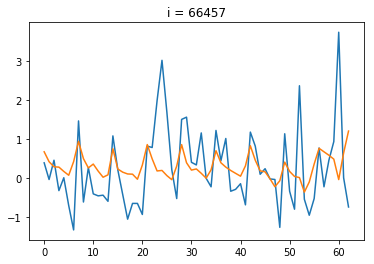

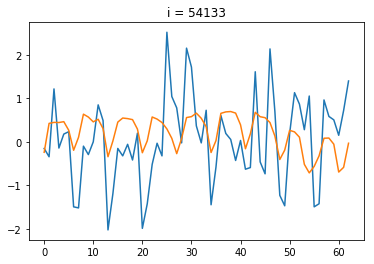

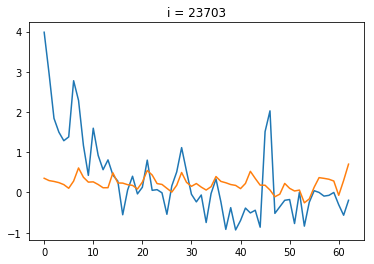

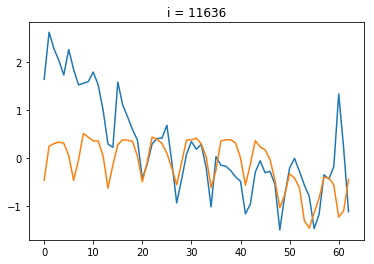

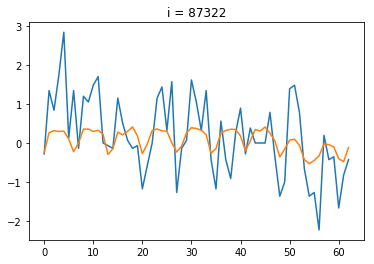

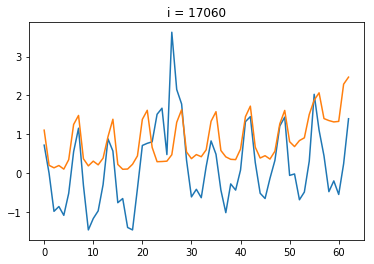

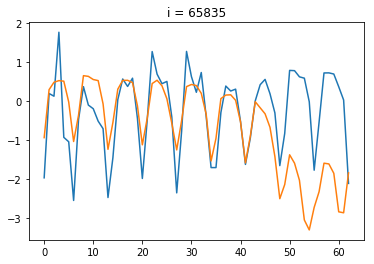

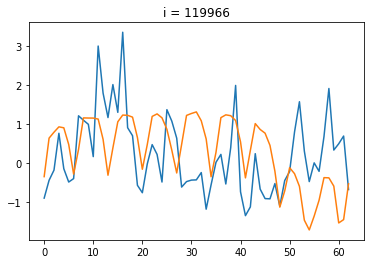

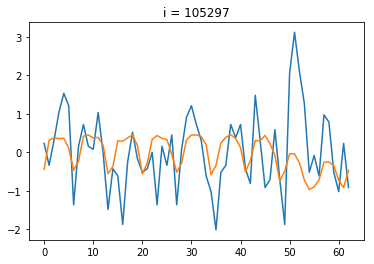

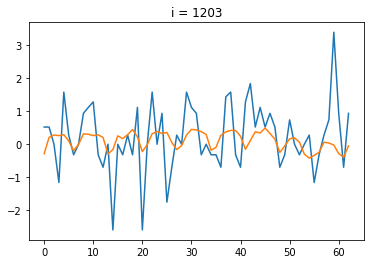

In [293]:
view_list = comp_examine(X_output, Y_output_pred, view_list=view_list)

In [294]:
view_list

[66457, 54133, 23703, 11636, 87322, 17060, 65835, 119966, 105297, 1203]

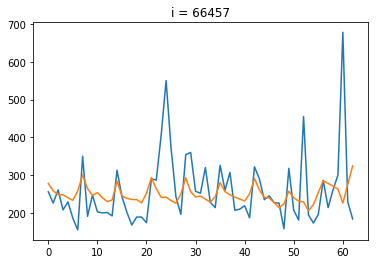

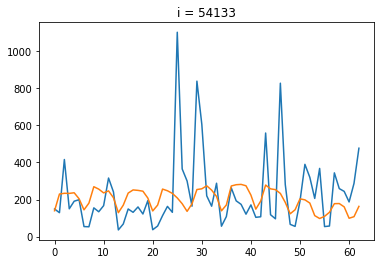

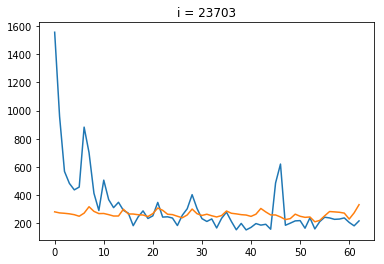

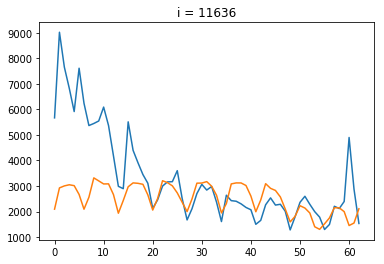

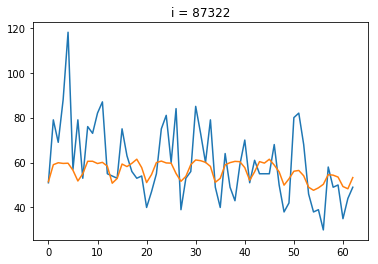

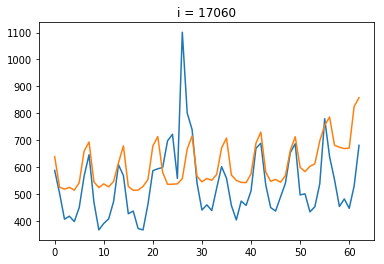

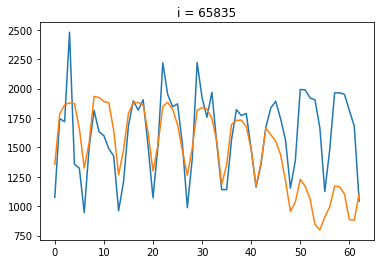

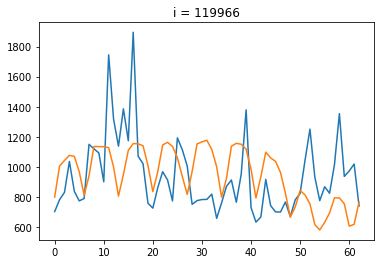

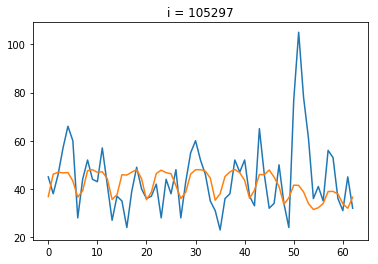

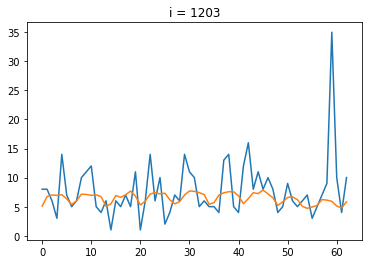

In [295]:
view_list = comp_examine(X_output_ori, Y_output_pred_ori, view_list=view_list)

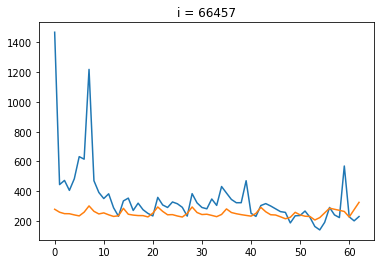

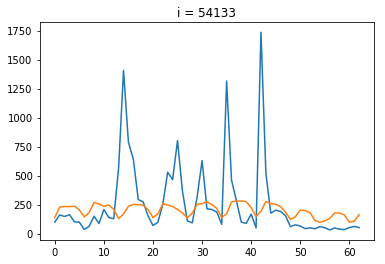

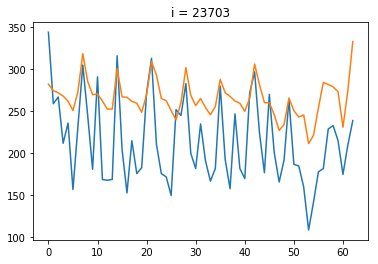

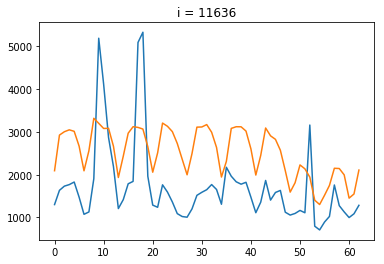

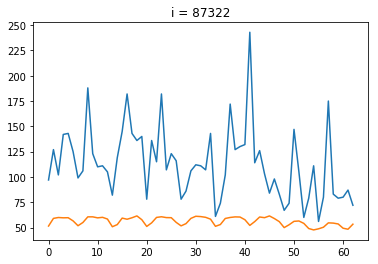

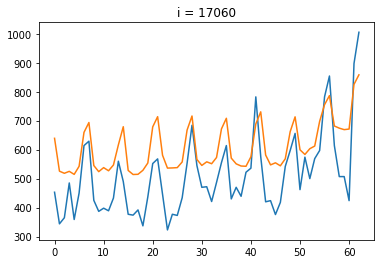

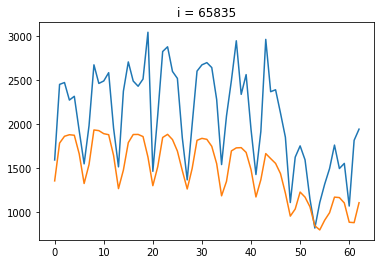

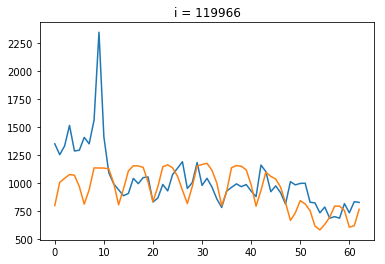

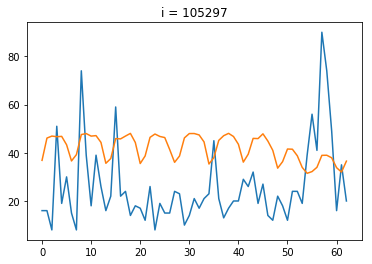

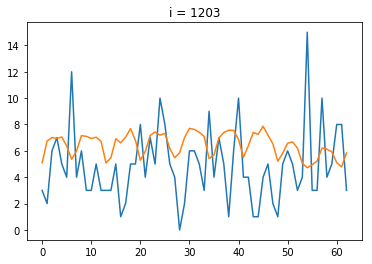

In [296]:
view_list = comp_examine(Y_input_ori, Y_output_pred_ori, view_list=view_list)

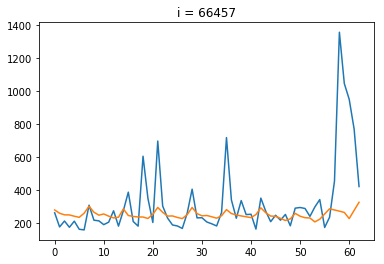

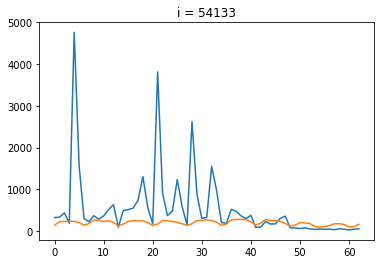

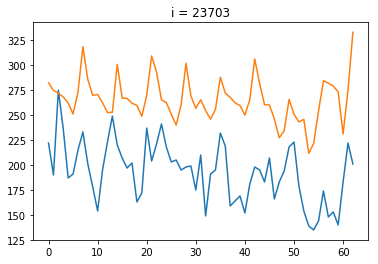

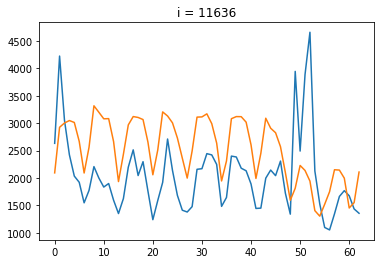

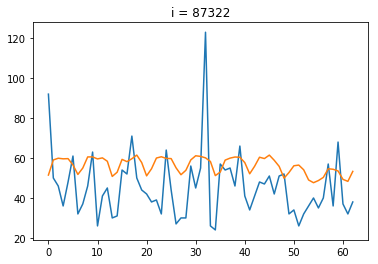

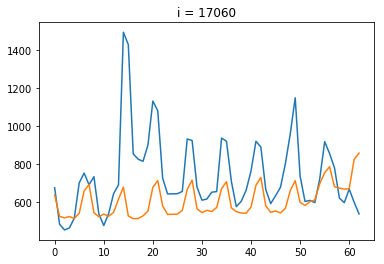

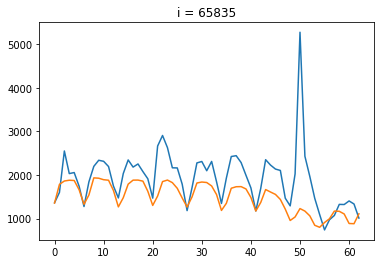

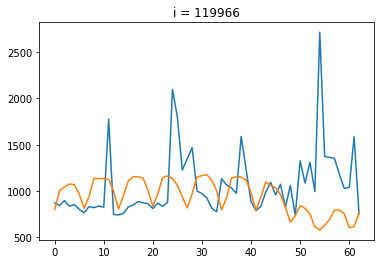

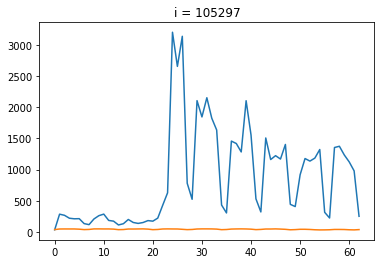

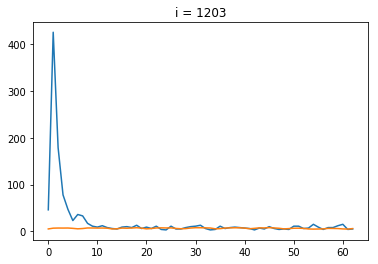

In [297]:
view_list = comp_examine(Y_output_ori, Y_output_pred_ori, view_list=view_list)

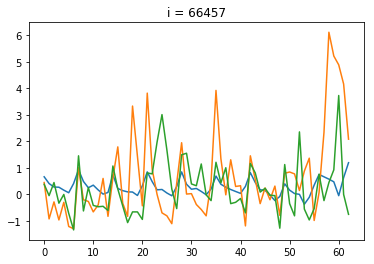

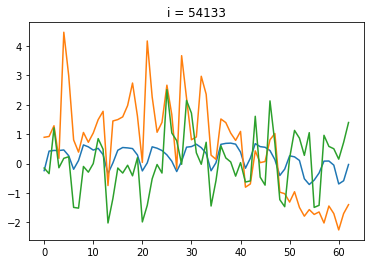

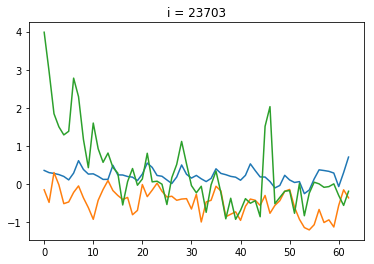

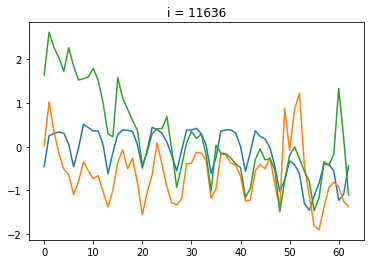

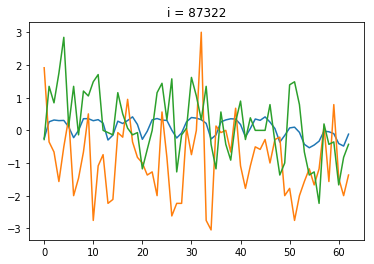

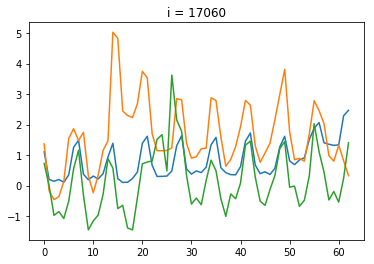

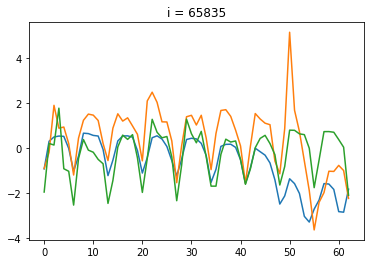

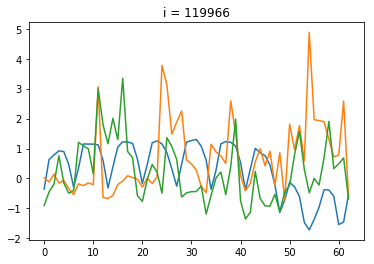

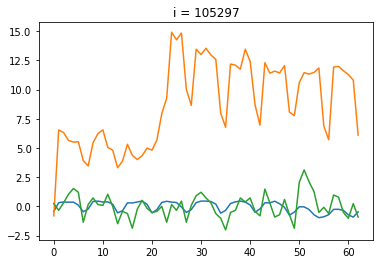

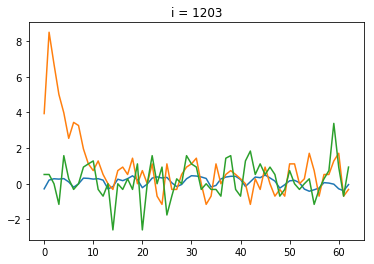

In [298]:
view_list = examine_list((Y_output_pred, Y_output, X_output), 
                         view_list=view_list)

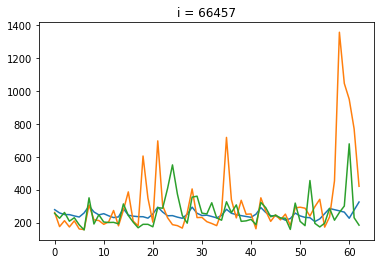

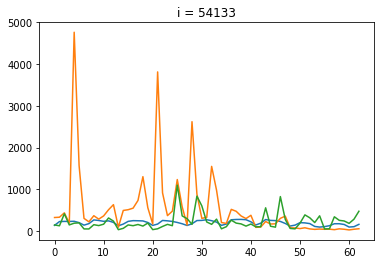

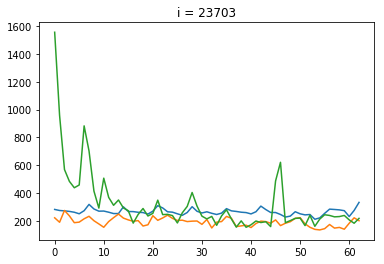

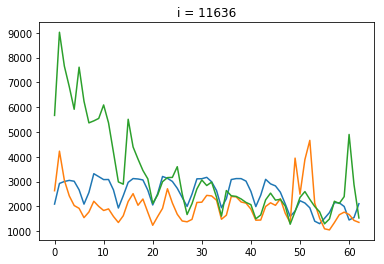

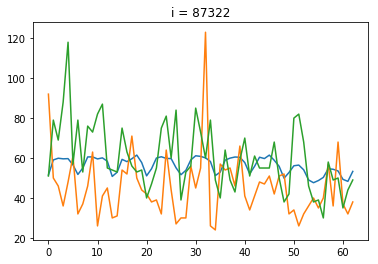

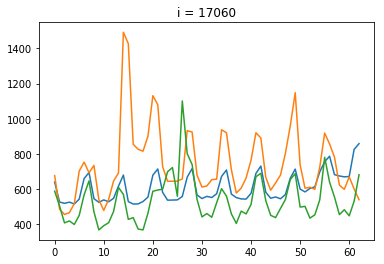

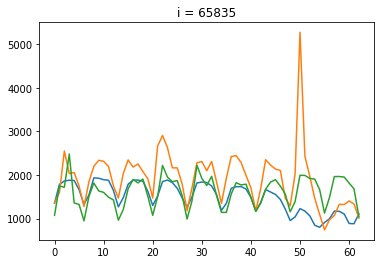

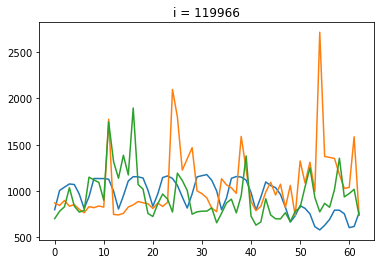

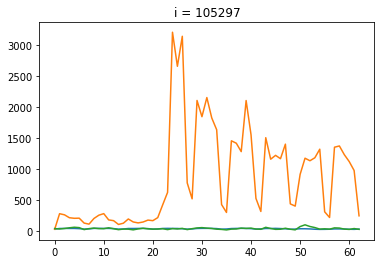

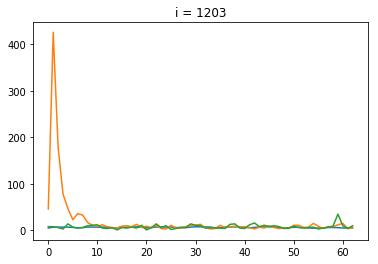

In [299]:
view_list = examine_list((Y_output_pred_ori, Y_output_ori, X_output_ori), 
                         view_list=view_list)

comp_examine(input_df.iloc[:,-63*2:-63].values,input_df.iloc[:,-63:].values, view_list=view_list)

#### Case 143557

In [300]:
i = 143557

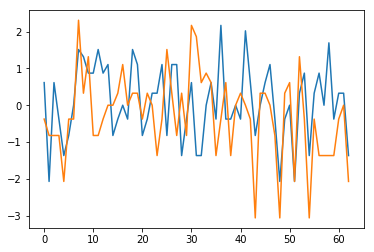

In [301]:
comp_view(X_input[i], Y_input[i])

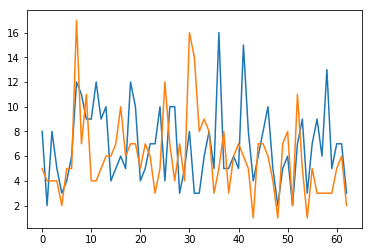

In [302]:
comp_view(X_input_ori[i], Y_input_ori[i])

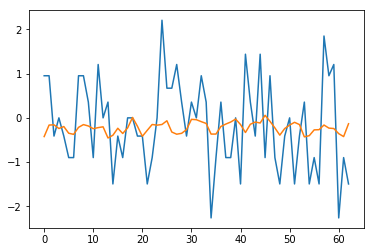

In [303]:
comp_view(X_output[i], Y_output_pred[i])

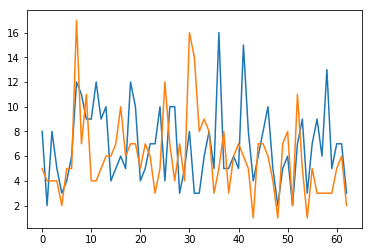

In [304]:
comp_view(X_input_ori[i], Y_input_ori[i])

In [305]:
input_center[i], output_center[i], input_scale[i], output_scale[i]

(array([ 0.84509804]),
 array([ 0.84509804]),
 array([ 0.17770392]),
 array([ 0.16257146]))

## Output

print('%%% Reading data key_1.csv ...', end = '', flush = True)
output_df = pd.read_csv("../data/key_1.csv")
print('done!')

output_df['date'] = output_df.Page.apply(lambda a: a[-10:])  # take the last 10 characters from 'Page' as date
output_df['Page'] = output_df.Page.apply(lambda a: a[:-11])  # remove the last 10 caharacters from 'Page'
output_df['date'] = output_df['date'].astype('datetime64[ns]')  # convert 'date' string to numpy datetime format
#test['weekday'] = test.date.dt.dayofweek  # find the day of week using the 'date' column
output_df

output_df.info()

output_df['date'].values[0:62]  # Make sure the range is 60 days (see if the dates resume after 60)

predict_dates_index=pd.date_range(Y_output_first_day, 
                                  periods=np.timedelta64(y_length,'D'), 
                                  freq = 'D', unit = 'D')
predict_dates_index

result_df = pd.DataFrame(Y_output_pred_ori, columns = predict_dates_index)
result_df

result_df['Page'] = input_df['Page']  # Append 'Page' column from input_df
result_df

result_flat_df = pd.melt(result_df, id_vars='Page', var_name='date',
                         value_name='Visits')
result_flat_df

output_df = output_df.merge(result_flat_df, how='left')  # fill the 'Visits" from result
output_df

#Check if there is null value
output_df.loc[output_df.Visits.isnull(), 'Visits']

#output_df.loc[output_df.Visits.isnull(), 'Visits'] = 0.0  # Uncommend this line to Replace NaN with 0.0

print('%%% Writing result for ' + model_name + ' ...', 
      end = '', flush = True)
#Write only the 'Id' and 'Visits' to the result file
output_df[['Id','Visits']].to_csv('../results/submit_1_' + model_name
                                + '.csv', index = False)
print('done!')

Kaggle Score: 

[6.0.0] 46.3 [Model 6.0.0 CNN - Conv(60, 7)-FC(120)-Drop(0.25)-FC(120)-Drop(0.5)-Linear, 20 epoches]

[6.1.0] 46.7 [Model 6.1.0 CNN - Conv(30, 7)-Conv(60, 7)-FC(120)-Drop(0.25)-FC(120)-Drop(0.5)-Linear, 20 epoches]